In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

## Explore *Oversampling* for Random Forest Classifier RACE Variable
- We have seen that our Random Forest classifier doesn't perform well on the observed data
- Before pursuing **extremely computationally expensive** cross validatiion, we want to see how a few "base" random forests models do on **randomly oversampled** data.
- We will use the library *adasyn* to create new, synthetic observations in our small classes via a nearest-neighbors method.

### Data Preparation and Cleaning
- This is lengthy code, but hopefully should be clear.

In [2]:
#Read in dataframe
df = pd.read_csv("data_train.csv")

In [3]:
#DATA CLEANING STEPS

#Steps to clean data by dropping columns where the number of empty rows is >= 445,000
dfComplete = df.dropna(1, thresh= 445000)
# dfComplete.shape #Results in (494932,58)

#Steps to clean data by dropping row where the number of empty columns is > 0
dfCompleteAll = dfComplete.dropna(0, how="any")
# dfCompleteAll.shape #results in a dataframe of (476155,58)

# dfCompleteAll.isnull().sum() #no more nulls in the dataset

In [4]:
#Extract Dataframe of Variables for Classification
y = dfCompleteAll[["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"]]
y.head()

,ASOURCE,ATYPE,RACE,TOTCHG,ZIPINC_QRTL
0,2,2,1,272123,3
1,2,2,1,209246,1
2,2,2,1,305474,1
3,2,2,1,202973,1
4,2,2,1,416072,1


In [5]:
"""The next step is to prepare variables for exploratory data analysis and feature
selection using a random forest. 

Random forest does not require standardization of continuous variables or normalization
of discrete variable. For categorical features, we will need to use pd.get_dummies or 
one hot encoding to create binary dummy variables. 
"""

#First create two dataframes of int and float values to make things easier to work with 
columnNames = dfCompleteAll.columns
dfFloat = pd.DataFrame()
dfInt = pd.DataFrame()
for name in columnNames:
    if dfCompleteAll[name].dtype == float:
        dfFloat = dfFloat.join(dfCompleteAll[name], how = "right")
    else:
        dfInt = dfInt.join(dfCompleteAll[name], how = "right")
        
#Convert all columns in DfFloat, except DISCWT, to integer values. Afterwards nominal features
#will be one-hot encoded to create dummy variables, again we will not normalize or stadardize
# numeric values. 

float_toInt = ['AGE', 'AMONTH', 'AWEEKEND', 'DIED', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'FEMALE', 'LOS', 'PAY1', 'HOSP_BEDSIZE', 'HOSP_CONTROL',
       'HOSP_LOCTEACH']
for digit in float_toInt:
    dfFloat[digit] = dfFloat[digit].astype(int)

In [6]:
# In dfFloat we have the following columns and feature groupings. 
# For reference use feature_desc or call .unique() method on one of the columns

# CONTINUOUS:
dfFloatContinuous = dfFloat[["AGE", "DISCWT"]]


# NOMINAL:
dfFloatNominal = dfFloat[['AMONTH', 'DISPUNIFORM', 'DXCCS1',
       'DXCCS2', 'PAY1', 'HOSP_CONTROL','HOSP_LOCTEACH']]

# BINARY & ORDINAL
dfBinaryOrdinal = dfFloat[["DIED", "AWEEKEND", "FEMALE", "HOSP_BEDSIZE"]]

# DISCRETE
dfDiscrete = dfFloat[["LOS"]]

In [7]:
#Use pd.get_dummies to turn nominal variables into dummy variables by first setting all 
#values as string, a requirement of pd.get_dummies. 

dfFloatNominal = dfFloatNominal.loc[:].astype(str)
    
dfFloatNominal = pd.get_dummies(dfFloatNominal)
dfFloatNominal.shape 

(475155, 556)

In [8]:
#Normally here, we might turn values in dfFloatContinuous to normalized, however,
#DTs and RFs do not require this. Later if we use a different classifier, we will need
# to standardize or normalize. 

#Normalization: rescaling features to a range of [0, 1], a special case of min-max scaling.

#Standardization: Often more practical, center the feature columns at mean 0 with 
# standard deviation 1 so that the feature columns take the form of a normal distribution, 
#This make it easier to learn the weights.

In [9]:
# We can now recreate the original dfFloat dataframe as dfFloatPreprocessed which 
# will have variables ready for feature selection with RF. Next the same thing must be down
#with dfInt
list_of_dataframes = [dfFloatContinuous, dfBinaryOrdinal, dfDiscrete, dfFloatNominal]

dfFloatPreprocessed = pd.DataFrame()
for frame in list_of_dataframes:
    dfFloatPreprocessed = dfFloatPreprocessed.join(frame, how = "right")
dfFloatPreprocessed.shape

(475155, 563)

In [10]:
#Prepare dfInt for preprocessing, starting with dropping respone variables
dfInt = dfInt.drop(["ASOURCE", "ATYPE", "RACE", "TOTCHG", "ZIPINC_QRTL"], axis= 1)
'''
Uncomment the code below to look at values in each column to see what needs to be dropped 
'''

# columnNamesInt = dfInt.columns

# for name in columnNamesInt:
#     print(name, dfInt[name].unique()) #Any values where 0,1 or ordinal e.g., DQTR we are good

'\nUncomment the code below to look at values in each column to see what needs to be dropped \n'

In [11]:
#CMs are all binary, therefore, create a separate dataframe for these columns: 
dfCm = dfInt[['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']]

#Update the dfInt dataframe to a new dataframe:
dfIntShort = dfInt.drop(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF',
       'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG',
       'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY',
       'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE',
       'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL',
       'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS'],axis = 1)

# columnNamesInt = dfIntShort.columns
# for name in columnNamesInt:
#     print(name, dfIntShort[name].unique()) #Any values where 0,1 or ordinal e.g., DQTR we are good

In [12]:
#Continue evaluating values in each column

#Since NDX, NPR, ORPROC, TOTAL_DISC are all either Binary or Discerete variables, create a separate dataframe
dfIntBinaryDiscrete = dfIntShort[["NDX", "NPR", "ORPROC", "TOTAL_DISC"]]

# Since DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION are all nominal variables, create a separate dataframe to 
#turn these into dummy variables. ALSO Drop "KEY" as this is the record id field: 
dfIntToDummies = dfIntShort.drop(["KEY", "NDX", "NPR", "ORPROC", "TOTAL_DISC"], axis= 1)


In [13]:
#Turn values in DQTR, HOSPID, MDC, NIS_STRATUM, HOSP_REGION to string
dfIntToDummies = dfIntToDummies.loc[:].astype(str)

#Use pd.get_dummies to turn nominal string values to binary dummy variables
dfIntToDummies = pd.get_dummies(dfIntToDummies)
# dfIntToDummies.head()

In [14]:
#Recombinet the three dataframes into a new preprocessed dataframe called dfIntPreprocessed
intRecombine = [dfIntToDummies, dfCm, dfIntBinaryDiscrete]

dfIntPreprocessed = pd.DataFrame()
for df in intRecombine:
    dfIntPreprocessed = dfIntPreprocessed.join(df, how = "right")
    
# dfIntPreprocessed.shape

In [15]:
#Combine the now preprocessed dfInt and dfFloat dataframes back in a single dataframe of either discrete, continuous,
#or binary variables. 
dfPreprocessed = dfFloatPreprocessed.join(dfIntPreprocessed, how = "right")
arrayPreprocessed = np.array(dfPreprocessed)
dfPreprocessed.head() #these are our predictors

,AGE,DISCWT,DIED,AWEEKEND,FEMALE,HOSP_BEDSIZE,LOS,AMONTH_1,AMONTH_10,AMONTH_11,...,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS,NDX,NPR,ORPROC,TOTAL_DISC
0,48,4.671227,0,0,0,1,83,0,0,1,...,0,0,0,0,0,1,18,7,1,409
1,66,4.671227,0,0,0,1,50,0,0,1,...,0,0,0,0,0,1,18,8,0,409
2,53,4.671227,0,0,0,1,65,0,0,1,...,0,0,0,0,0,1,18,6,0,409
3,27,4.671227,0,0,1,1,59,0,0,1,...,0,0,0,0,0,1,18,4,0,409
4,48,4.671227,1,0,0,1,77,0,0,1,...,1,1,0,0,0,1,18,8,0,409


## RACE Variable Class Distribution:

1    326960
2     83746
3     38750
6     18408
4      6561
5       730
Name: RACE, dtype: int64

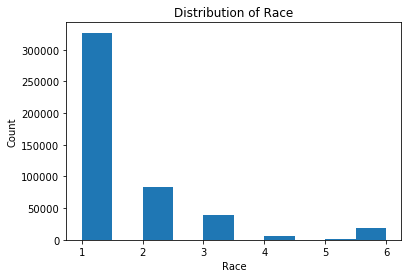

In [16]:
#Look at distribution of Race
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y["RACE"], histtype="bar")
plt.title("Distribution of Race")
plt.ylabel("Count")
plt.xlabel("Race")

y.RACE.value_counts()

In [17]:
#before we do anything, we need to plug our DFs back together so other features can help predict race.
dfFull = pd.concat([dfPreprocessed, y], axis=1)

X_race = dfFull.drop(['RACE'], axis=1) #all columns except race
y_race = dfFull.RACE #RACE column

#CRUCIALLY, must do a train test split before any resampling; we HAVE to hold out observed test data
race_X_tr, race_X_te, race_y_tr, race_y_te = train_test_split(X_race, y_race, test_size = 0.33,
                                                                       random_state = 12)

In [18]:
#fitting a random forest with 800 attributes and 475k rows ain't gonna fly on my MacBook Air. 
#so we'll randomly sample 50,000 rows of our X, y train splits; then we'll make some data from there

#we actually have to plug these dfs back together; this is inefficient code but want to ensure 
#train/test are kept fully separate with no information bleed

fullTrain = pd.concat([race_X_tr, race_y_tr], axis=1) #this is a full df of all 318 rows in train split
sampleTrain = fullTrain.sample(n=50000, random_state=12) #now pluck 50k rows from this 318k row df

#now split out into variables again. I didn't say this code was efficient, but it's hopefully clear
sample_race_X_tr = sampleTrain.drop(['RACE'], axis=1) 
sample_race_y_tr = sampleTrain.RACE

We will use these sample_race_X_train and sample_race_X_test for over- and under-sampling.

## Experiment with Two Methods of Oversampling Minority Classes:

### Synthentic Oversampling
- We make up data "similar" (questionable in high dimension space) to the observed data for minority classes

In [94]:
ada = ADASYN(ratio = 'all', random_state = 12, n_jobs = -1) 
ada_rXtr, ada_rytr = ada.fit_sample(sample_race_X_tr, sample_race_y_tr) #creates numpy arrays

In [98]:
old_counts = sample_race_y_tr.value_counts()
new_counts = Counter(ada_rytr)

print("Old Counts:")
print(old_counts)

print("Resampled Counts: {}".format(new_counts))

Old Counts:
1    34302
2     8903
3     4137
6     1932
4      653
5       73
Name: RACE, dtype: int64
Resdampled Counts: Counter({3: 35615, 5: 34310, 1: 34302, 4: 34215, 6: 33915, 2: 32494})


### Random forest on ADASYN Sample:

In [99]:
ada_clf = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=400,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True,random_state=12)


ada_clf.fit(ada_rXtr, ada_rytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [100]:
ada_model_predictions = ada_clf.predict(race_X_te)
ada_model_accuracy = accuracy_score(race_y_te, ada_model_predictions)
print('ADASYN Model Accuracy Score: {}'.format(ada_model_accuracy))

ADASYN Model Accuracy Score: 0.7650922819861992


In [102]:
pd.crosstab(race_y_te, ada_model_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,6
Actual Race,,,,,
1,104332,3141,483,14,114
2,14817,9977,2494,3,199
3,6113,2215,4363,5,105
4,1659,386,90,3,25
5,205,15,18,0,1
6,2953,1257,517,5,1293


In [101]:
ada_model_report = classification_report(race_y_te, ada_model_predictions)
print(ada_model_report)

             precision    recall  f1-score   support

          1       0.80      0.97      0.88    108084
          2       0.59      0.36      0.45     27490
          3       0.55      0.34      0.42     12801
          4       0.10      0.00      0.00      2163
          5       0.00      0.00      0.00       239
          6       0.74      0.21      0.33      6025

avg / total       0.73      0.77      0.73    156802



/Users/nathanzencey1/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Don't even understand how it can be so bad, but OK.

## Random Oversample with Completely Equal Class Counts
- Let's see if completely equal class counts produce better results.

In [116]:
ros = RandomOverSampler(random_state=12) #automatically oversamples minority classes to be equal with maj
ros_rXtr, ros_rytr = ros.fit_sample(sample_race_X_tr, sample_race_y_tr) #creates numpy arrays

In [117]:
ros_counts = Counter(ros_rytr)
ros_counts

Counter({1: 34302, 2: 34302, 3: 34302, 4: 34302, 5: 34302, 6: 34302})

In [118]:
ros_clf = RandomForestClassifier(n_jobs=-1,max_features='auto',n_estimators=400,max_depth=250,min_samples_split=5,
                             min_samples_leaf=1,oob_score = True,random_state=12)


ros_clf.fit(ros_rXtr, ros_rytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=True, random_state=12, verbose=0, warm_start=False)

In [119]:
ros_model_predictions = ros_clf.predict(race_X_te)
ros_model_accuracy = accuracy_score(race_y_te, ros_model_predictions)
ros_model_accuracy

0.7635680667338427

In [121]:
ros_model_report = classification_report(race_y_te, ros_model_predictions)
print(ros_model_report)

             precision    recall  f1-score   support

          1       0.84      0.92      0.88    108084
          2       0.54      0.50      0.52     27490
          3       0.51      0.38      0.44     12801
          4       0.09      0.01      0.02      2163
          5       0.33      0.00      0.01       239
          6       0.63      0.25      0.36      6025

avg / total       0.74      0.76      0.74    156802



In [122]:
pd.crosstab(race_y_te, ros_model_predictions, rownames=['Actual Race'], colnames=['Predicted Race'])

Predicted Race,1,2,3,4,5,6
Actual Race,,,,,,
1,99477,7042,1118,91,0,356
2,10485,13834,2825,39,1,306
3,4993,2720,4889,25,0,174
4,1427,540,133,18,0,45
5,183,27,25,2,1,1
6,2349,1523,621,21,1,1510


### We find that systematic oversampling (somewhat surprisingly) does little to improve model performance. We choose to pursue a majority class undersampling strategy (see accompanying .ipynb).